In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from cnn import CNN

import pygad
import time

### Preprocess

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [4]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [5]:
start_idx = 18000
end_idx = 18100
duration = end_idx - start_idx

In [6]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(100, 96)

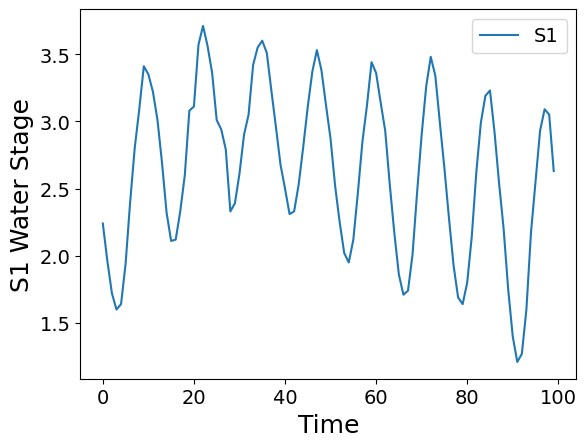

In [7]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [8]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(100, 96, 16)
(153600,)


In [9]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(100, 96, 7)
(67200,)


In [10]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(100, 96, 2)


In [11]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(100, 96, 7)


### GA

In [12]:
saved_model = load_model('cnn.h5', compile=False)

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [14]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [16]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

CPU time: 1204.3867611 seconds


In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.4662202  0.12625983 0.27011163 ... 0.55669556 0.64067156 0.42923685]
Fitness value of the best solution = 0.0002665135867669052


### Post-processing

In [18]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

4/4 [==============================] - 0s 2ms/step


In [19]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

158


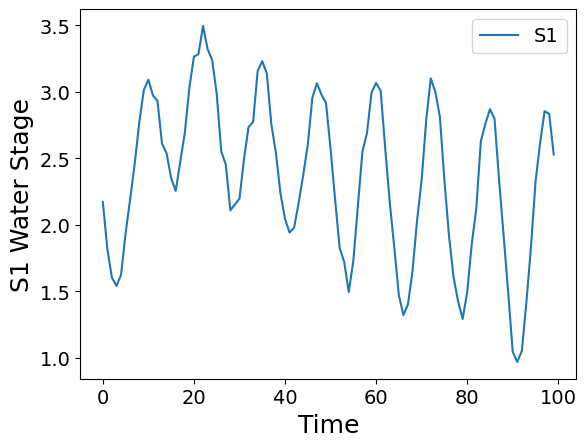

In [20]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [21]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA results/best_gate_event6.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.466220,0.126260,0.270112,0.974671,0.646235,0.209694,0.160906,0.369036,0.389887,0.416251,...,0.983351,0.705740,0.515395,0.274940,0.706379,0.733987,0.466283,0.352532,0.859476,0.811836
1,0.466022,0.950209,0.747710,0.784114,0.435701,0.024966,0.870368,0.392341,0.734499,0.711168,...,0.830766,0.743086,0.374587,0.608284,0.079555,0.442884,0.456379,0.150976,0.568334,0.158462
2,0.285603,0.016521,0.353717,0.071587,0.068752,0.783555,0.864029,0.922045,0.369755,0.439564,...,0.936891,0.969352,0.729365,0.793634,0.727957,0.358971,0.125412,0.434027,0.672588,0.949089
3,0.546962,0.029733,0.214880,0.505400,0.448739,0.160479,0.609470,0.417243,0.376974,0.735795,...,0.809889,0.143534,0.427812,0.907685,0.919009,0.707221,0.368690,0.708798,0.681253,0.367331
4,0.590206,0.994433,0.485548,0.241337,0.368146,0.150120,0.493184,0.435627,0.771915,0.349027,...,0.002450,0.268816,0.446975,0.869728,0.180495,0.469656,0.676308,0.406890,0.469527,0.841350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.095000,0.168682,0.599035,0.142561,0.362103,0.278110,0.666383,0.645215,0.323968,0.134293,...,0.385904,0.308158,0.333592,0.228438,0.344820,0.453808,0.379412,0.842847,0.856887,0.852225
96,0.424821,0.121249,0.723267,0.358168,0.466406,0.790102,0.507064,0.069484,0.259893,0.456300,...,0.191537,0.191652,0.946779,0.625665,0.386893,0.918454,0.292384,0.589344,0.596356,0.608422
97,0.454909,0.338821,0.716947,0.080514,0.732122,0.233153,0.890684,0.066633,0.780671,0.053255,...,0.654324,0.549597,0.878088,0.858587,0.525731,0.256709,0.032529,0.714262,0.162300,0.668660
98,0.840992,0.684107,0.273808,0.269582,0.108220,0.974267,0.263338,0.625720,0.829123,0.381805,...,0.365386,0.874599,0.647833,0.745859,0.159715,0.641460,0.557086,0.542571,0.481343,0.642655


In [22]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA results/best_performance_event6.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.172096,2.202529,2.243448,2.405060,2.026079,2.157902,2.155101,2.207274,1.776880,1.975188,...,3.371753,3.864911,3.605386,3.774129,3.567355,4.067598,3.542753,3.771916,3.557716,3.999845
1,1.816427,1.884001,1.941323,2.116678,1.659802,1.772965,1.812720,1.905019,1.465626,1.567729,...,3.363844,3.824607,3.402729,3.541056,3.409302,3.831223,3.224288,3.482399,3.287533,3.650911
2,1.603190,1.677496,1.773152,1.921159,1.622971,1.673831,1.779180,1.883509,1.644779,1.680942,...,3.308592,3.714378,3.248522,3.387216,3.244797,3.647103,3.081691,3.290915,3.140262,3.501883
3,1.541618,1.622997,1.646095,1.769646,1.626147,1.710574,1.732543,1.835739,1.779882,1.828214,...,3.070805,3.503953,2.987149,3.120165,2.924199,3.262564,2.840153,3.173940,2.871150,3.131904
4,1.624164,1.627957,1.622255,1.834191,1.839553,1.877963,1.827518,2.069785,2.084263,2.189807,...,2.855178,3.257375,2.731135,2.924128,2.670664,3.011742,2.512362,2.865152,2.509662,2.802973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.322049,2.275404,2.383733,2.579825,2.785763,2.691493,2.817361,3.046707,2.992453,2.871346,...,1.062394,0.898711,0.756791,0.846804,1.109380,1.059119,1.098958,1.035496,1.322208,1.348236
96,2.614661,2.633836,2.584923,2.880415,2.889839,2.860404,2.873806,3.160908,2.893228,2.867049,...,1.221470,1.123668,1.248968,1.412687,1.498011,1.563404,1.671610,1.842925,1.834683,2.021759
97,2.854671,2.863886,2.888393,3.142581,2.899923,2.901055,2.962945,3.237851,2.585939,2.594160,...,1.520031,1.467883,1.800619,1.939686,1.967083,2.078684,2.226807,2.299922,2.361692,2.543227
98,2.834146,2.837354,2.906632,3.097730,2.625989,2.663418,2.763389,2.923941,2.160644,2.233412,...,1.899866,1.974492,2.291092,2.432990,2.380765,2.580069,2.674633,2.754010,2.784751,2.973804
